In [4]:
import numpy as np
x_train = np.load('../test/x_train.npy')
y_train = np.load('../test/y_train.npy')
x_test = np.load('../test/x_test.npy')
y_test = np.load('../test/y_test.npy')

In [13]:
x_train.shape

(6, 731, 7)

In [2]:
from model.__model import train, RMSELoss, GlobalLSTM

model = GlobalLSTM(hidden_size=256)
loss_func = RMSELoss()
model = train(model, x_train, y_train, loss_func, epochs=500)

epoch: 1, loss: 0.10499287396669388, time: 3.553032398223877
epoch: 2, loss: 0.05705791339278221, time: 3.4356863498687744
epoch: 3, loss: 0.044096771627664566, time: 3.3920505046844482
epoch: 4, loss: 0.03604292497038841, time: 3.429745674133301
epoch: 5, loss: 0.031047850847244263, time: 3.49320387840271
epoch: 6, loss: 0.027486030012369156, time: 3.2279059886932373
epoch: 7, loss: 0.02533257193863392, time: 3.4585084915161133
epoch: 8, loss: 0.023775290697813034, time: 3.516453266143799
epoch: 9, loss: 0.022927919402718544, time: 3.329618215560913
epoch: 10, loss: 0.023672688752412796, time: 3.388010263442993
epoch: 11, loss: 0.021688761189579964, time: 3.4612057209014893
epoch: 12, loss: 0.02161685936152935, time: 3.6233534812927246
epoch: 13, loss: 0.021016251295804977, time: 3.4382357597351074
epoch: 14, loss: 0.020833676680922508, time: 3.350468397140503
epoch: 15, loss: 0.019584327936172485, time: 3.2938170433044434
epoch: 16, loss: 0.02015121839940548, time: 3.647838830947876


epoch: 131, loss: 0.012044457718729973, time: 3.5522069931030273
epoch: 132, loss: 0.011780292727053165, time: 3.422316551208496
epoch: 133, loss: 0.011924502439796925, time: 3.4204299449920654
epoch: 134, loss: 0.012314491905272007, time: 3.549318790435791
epoch: 135, loss: 0.011880754493176937, time: 3.475339412689209
epoch: 136, loss: 0.012177797965705395, time: 3.3591926097869873
epoch: 137, loss: 0.011733908206224442, time: 3.512347459793091
epoch: 138, loss: 0.01216364186257124, time: 3.4350337982177734
epoch: 139, loss: 0.011738174594938755, time: 3.453200340270996
epoch: 140, loss: 0.011527229100465775, time: 3.329998731613159
epoch: 141, loss: 0.012100180611014366, time: 3.462064743041992
epoch: 142, loss: 0.011830064468085766, time: 3.506915330886841
epoch: 143, loss: 0.012073689140379429, time: 3.4555928707122803
epoch: 144, loss: 0.012116139754652977, time: 3.4074437618255615
epoch: 145, loss: 0.011684727855026722, time: 3.467062473297119
epoch: 146, loss: 0.011760166846215

epoch: 259, loss: 0.010998353362083435, time: 3.692920446395874
epoch: 260, loss: 0.01085379347205162, time: 3.9721245765686035
epoch: 261, loss: 0.011259007267653942, time: 4.011292934417725
epoch: 262, loss: 0.01107160747051239, time: 4.011821269989014
epoch: 263, loss: 0.01117276307195425, time: 3.754645586013794
epoch: 264, loss: 0.011143822222948074, time: 3.7355213165283203
epoch: 265, loss: 0.010987168177962303, time: 4.021031618118286
epoch: 266, loss: 0.011280225589871407, time: 4.010220289230347
epoch: 267, loss: 0.010842950083315372, time: 3.829146385192871
epoch: 268, loss: 0.011632271111011505, time: 4.104304075241089
epoch: 269, loss: 0.011176791042089462, time: 3.5029563903808594
epoch: 270, loss: 0.011045020073652267, time: 3.432385206222534
epoch: 271, loss: 0.011714889667928219, time: 3.514976978302002
epoch: 272, loss: 0.01128311175853014, time: 3.498523473739624
epoch: 273, loss: 0.011259716004133224, time: 3.534147024154663
epoch: 274, loss: 0.010870874859392643, t

epoch: 387, loss: 0.010410336777567863, time: 3.441685438156128
epoch: 388, loss: 0.011187538504600525, time: 3.606813669204712
epoch: 389, loss: 0.011314231902360916, time: 3.5872554779052734
epoch: 390, loss: 0.011077105067670345, time: 3.5426104068756104
epoch: 391, loss: 0.011046906001865864, time: 3.5366933345794678
epoch: 392, loss: 0.010735787451267242, time: 3.6094422340393066
epoch: 393, loss: 0.010496541857719421, time: 3.4967195987701416
epoch: 394, loss: 0.01094452477991581, time: 3.288327693939209
epoch: 395, loss: 0.010642679408192635, time: 3.30644154548645
epoch: 396, loss: 0.010328378528356552, time: 3.349781036376953
epoch: 397, loss: 0.010944308713078499, time: 3.5032565593719482
epoch: 398, loss: 0.010260681621730328, time: 3.3540501594543457
epoch: 399, loss: 0.010843939147889614, time: 3.461179494857788
epoch: 400, loss: 0.010868582874536514, time: 3.474987506866455
epoch: 401, loss: 0.010746940039098263, time: 3.481656789779663
epoch: 402, loss: 0.010475399903953

In [17]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model(x_test)

for i in range(6):
    print(np.corrcoef(np.squeeze(y_test[i,:]), np.squeeze(y_pred[i,:]))[0,1])
    print(r2_score(np.squeeze(y_test[i,:]), np.squeeze(y_pred[i,:])))
    print(np.sqrt(mean_squared_error(np.squeeze(y_test[i,:]), np.squeeze(y_pred[i,:]))))

0.7591338885955432
-0.762721021696239
0.023620606013798954
0.7749346527378639
-6.215072691236134
0.06332248121387651
0.809571474369686
0.5340896357256666
0.013407576136174985
0.7996880000259347
0.46030252783176406
0.015300364985777862
0.8341491003759628
0.6491357021128907
0.012113223475553428
0.8288526462339292
0.6261346073303159
0.01280288823901347


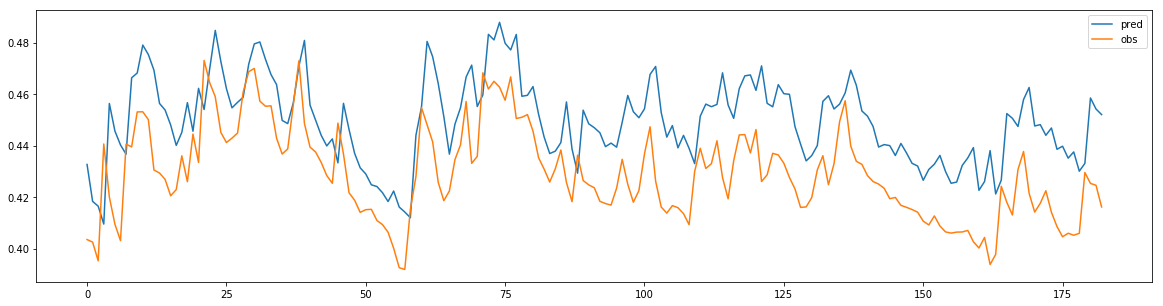

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(y_pred[0])
plt.plot(y_test[0])
plt.legend(['pred','obs'])

In [ ]:
from model.__model import GlobalLSTM
from model.__train_model import train, rmse_loss

model = GlobalLSTM(256)

model = train(model,
      x_train,
      y_train,
      loss_func=rmse_loss,
      epochs=10,
      batch_size=6,
      rho=30)
model.train(mode=False)
import torch
x_test = torch.Tensor(x_test).float().cuda()
#x_test = torch.from_numpy(x_test_)
yp = model(x_test)
m = np.array(yp.cuda().data.cpu().numpy())

tf.Tensor(98.96568, shape=(), dtype=float32)
epoch 0: MSE is 0.43028557300567627, cost time: 18.514955043792725
tf.Tensor(67.82648, shape=(), dtype=float32)
epoch 1: MSE is 0.29489773511886597, cost time: 17.77572202682495


In [6]:
from sklearn.metrics import r2_score, mean_squared_error
for i in range(6):
    print(r2_score(y_test[i,:], m[i,:]))
    print(np.sqrt(mean_squared_error(y_test[i, :], m[i,:])))

0.5688472301594292
0.011681936308393818
0.598348267244182
0.014940405702957366
0.6797533918444221
0.011115816156268851
0.32518909213192093
0.017108725012636463
0.7068575821064038
0.01107208657374262
0.6825446798301638
0.011797544557035109
